In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.prw import PRW
from src.sinkhorn import RBCD, round_plan
from src.utils import norm_inf
from demo import gen_gaussian, gen_fragmented_hypercube
from visualize import visualize_2D_plan, visualize_3D_plan

SEED = 3698

## Preparation

In [2]:
d = 3

n = 10
m = 20

k_star = 3
k = 2

In [3]:
a = np.ones(n, dtype=np.float64) / n
b = np.ones(m, dtype=np.float64) / m

X, Y = gen_gaussian(n, m, d, k_star, seed=SEED)
# X, Y = gen_fragmented_hypercube(n, m, d, k_star, seed=SEED)

In [4]:
prw = PRW(X, Y, a, b)

In [5]:
eta = 10.0
eprw = prw.entropic_regularize(eta)

## Solving with Sinkhorn-like Iterations

In [6]:
# Initial u and v
u0, v0 = np.zeros(n), np.zeros(m)

# Initial U
U0, _ = np.linalg.qr(np.random.randn(d, k))

# Regularization parameters
tau = np.float64(0.1)

# Accuracy threshold
eps_1 = np.float64(0.01)
eps_2 = np.float64(0.01)

# Run algorithm
log = RBCD(eprw, u0, v0, U0, tau, eps_1, eps_2, save_uv=True, save_U=True)

## Visualize

In [7]:
u, v = log['u'][-1], log['v'][-1]
U = log['U'][-1]

C = eprw.calc_proj_cost(U)
pi = round_plan(eprw.calc_pi(u, v, C), a, b)

f = log['f'][-1]

In [8]:
print(U)

[[-0.04077083  0.58725536]
 [-0.68313965 -0.60679007]
 [ 0.72914879 -0.53566497]]


In [9]:
print(f)

12.586606476624587


### Visualize plan

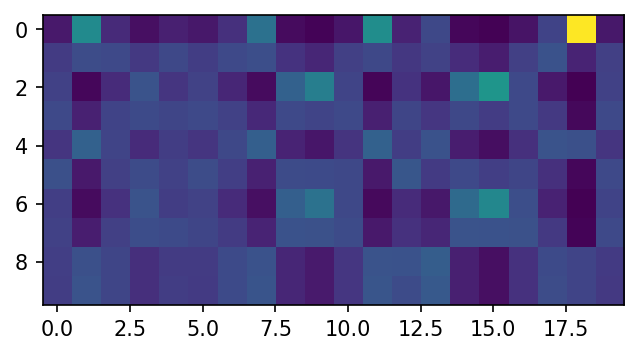

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)
ax.imshow(pi)
plt.show()

In [11]:
visualize_3D_plan(X, Y, U, pi)

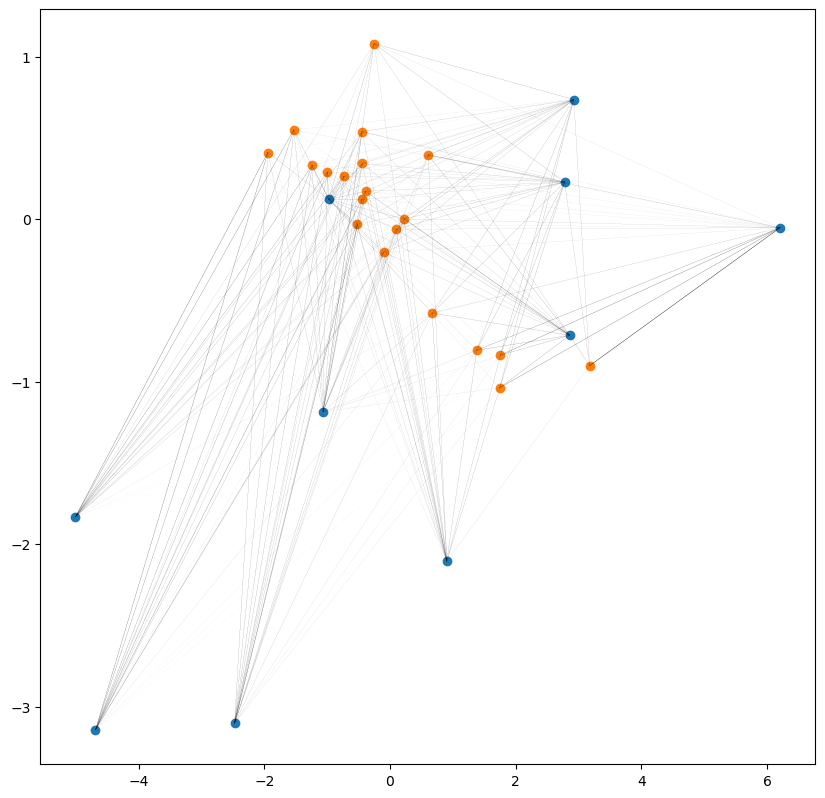

In [12]:
visualize_2D_plan(X, Y, U, pi)

### Convergence

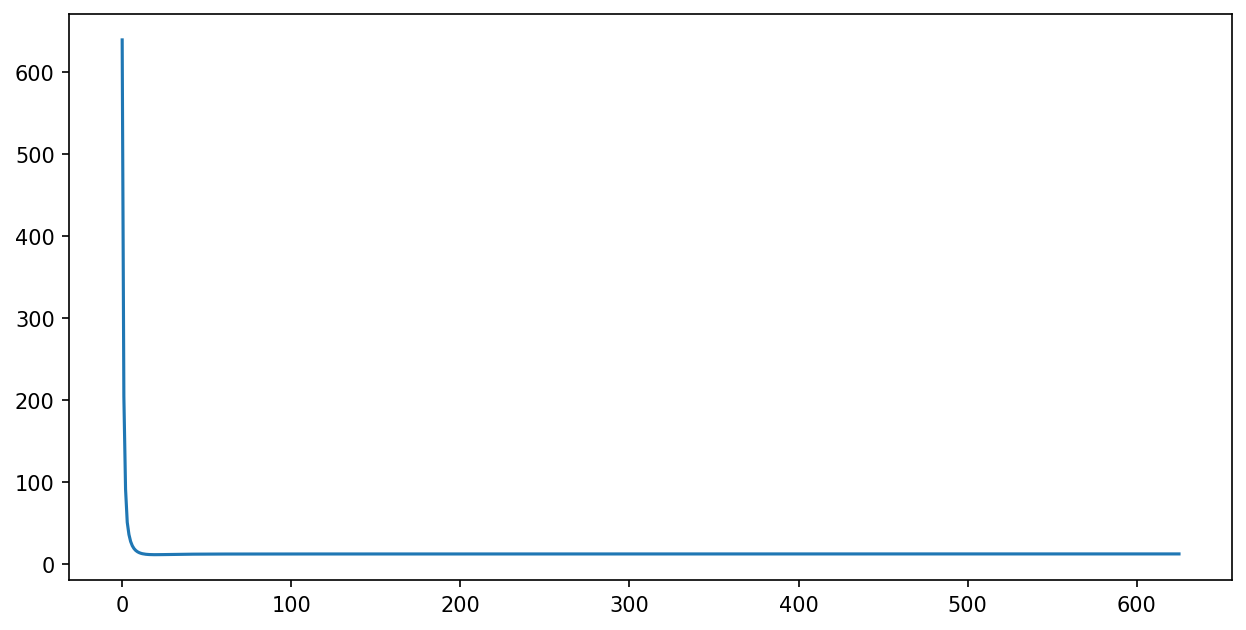

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
ax.plot(log['f'])
plt.show()

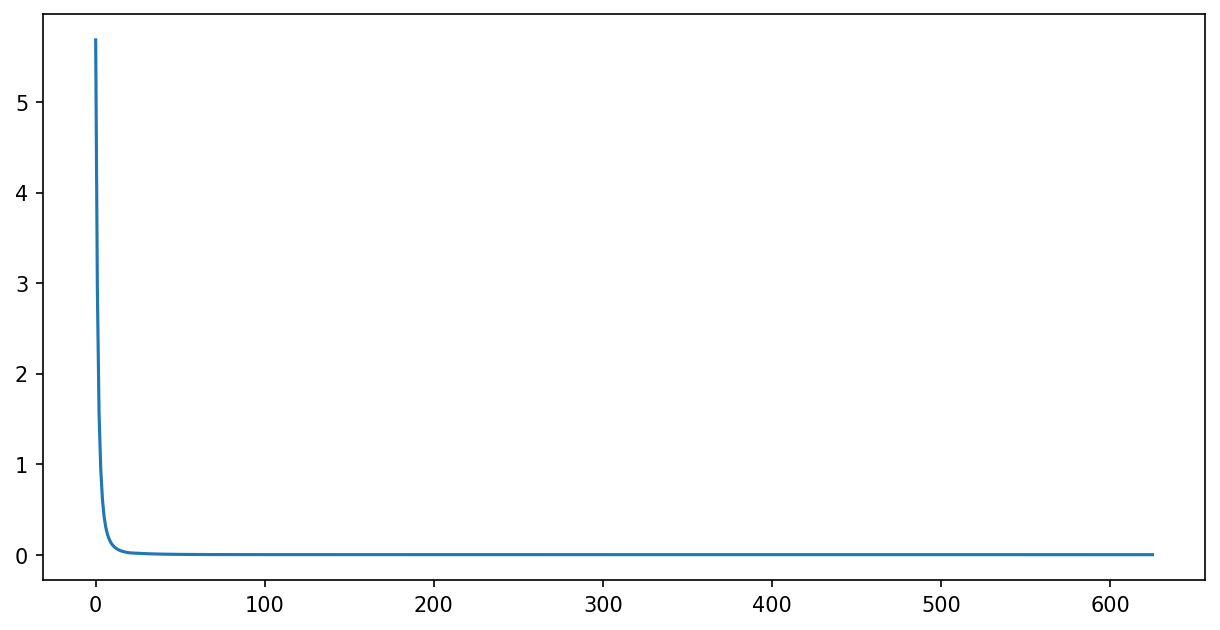

In [14]:
y = []
for uk, vk, Uk in zip(log['u'], log['v'], log['U']):
    pi_k = eprw.calc_pi(uk, vk, eprw.calc_proj_cost(Uk))
    y.append(norm_inf(pi_k.sum(-1) - a))

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
ax.plot(y)
plt.show()

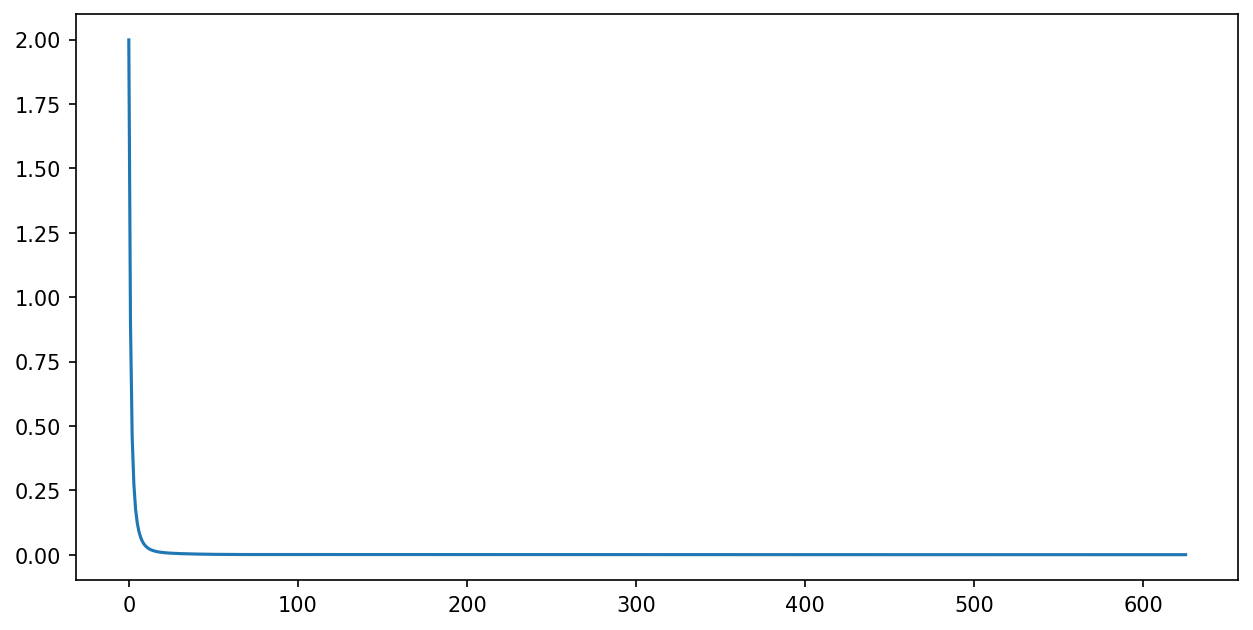

In [15]:
y = []
for uk, vk, Uk in zip(log['u'], log['v'], log['U']):
    pi_k = eprw.calc_pi(uk, vk, eprw.calc_proj_cost(Uk))
    y.append(norm_inf(pi_k.sum(0) - b))

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
ax.plot(y)
plt.show()

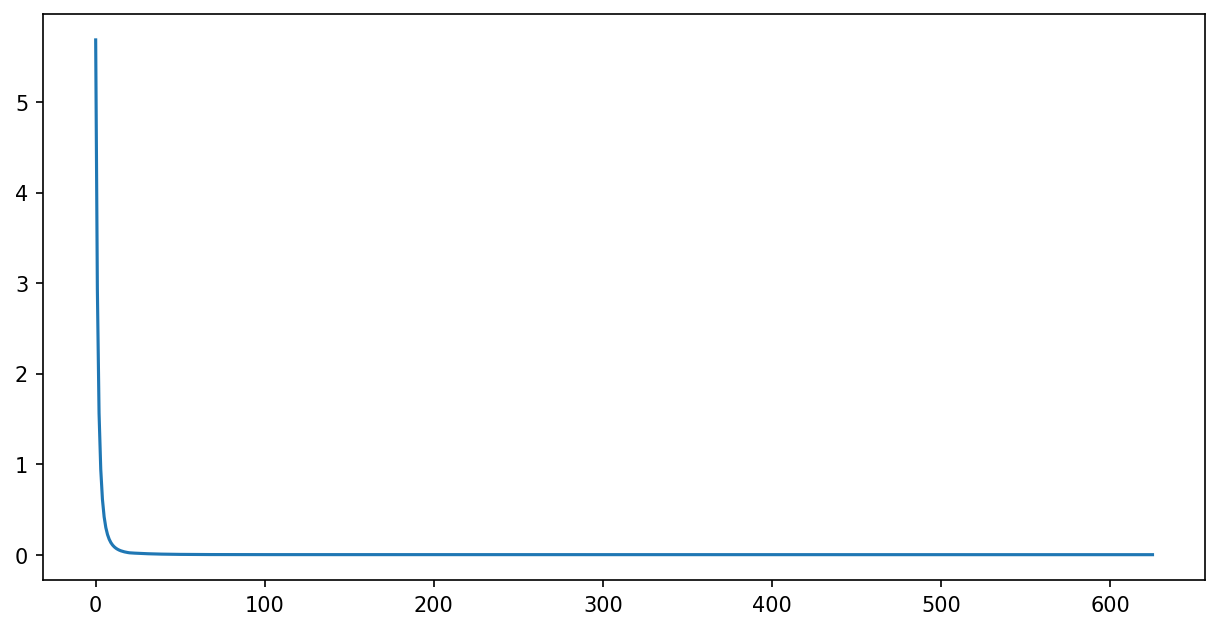

In [16]:
y = []
for uk, vk, Uk in zip(log['u'], log['v'], log['U']):
    pi_k = eprw.calc_pi(uk, vk, eprw.calc_proj_cost(Uk))
    y.append(max(norm_inf(pi_k.sum(-1) - a), norm_inf(pi_k.sum(0) - b)))

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=150)
ax.plot(y)
plt.show()